In [32]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
import fastai

In [33]:
from my_nn_modules import AE_big

In [34]:
torch.cuda.is_available()

True

In [35]:
#fastai.torch_core.defaults.device = 'cuda'

In [36]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


In [37]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [38]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [39]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [40]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [41]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f6a22531810>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f6a2494a4d0>;

Test: None

In [42]:
class AE_big(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.en2 = nn.Linear(200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.en3 = nn.Linear(100, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.en4 = nn.Linear(50, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 50)
        self.bn6 = nn.BatchNorm1d(50)
        self.de2 = nn.Linear(50, 100)
        self.bn7 = nn.BatchNorm1d(100)
        self.de3 = nn.Linear(100, 200)
        self.bn8 = nn.BatchNorm1d(200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        h1 = self.tanh(self.bn1(self.en1(x)))
        h2 = self.tanh(self.bn2(self.en2(h1)))
        h3 = self.tanh(self.bn3(self.en3(h2)))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.bn6(self.tanh(self.de1(self.bn5(self.tanh(x)))))
        h6 = self.bn7(self.tanh(self.de2(h5)))
        h7 = self.bn8(self.tanh(self.de3(h6)))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        pass

In [43]:
model = AE_big()

In [44]:
#def my_loss_func(input, target):
#    np.power(target - input, 2).mean()
loss_func = nn.MSELoss()
#loss_func = my_loss_func
#loss_func = model.ae_loss
#learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [45]:
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [46]:
from fastai import train as tr
tr.lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


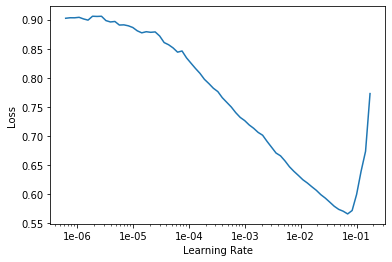

In [47]:
learn.recorder.plot()

In [48]:
lr = 1e-3
learn.fit_one_cycle(2, max_lr=lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.014402,0.012343,00:55
1,0.006627,0.000917,00:55


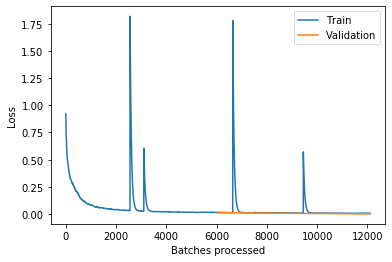

In [49]:
learn.recorder.plot_losses()

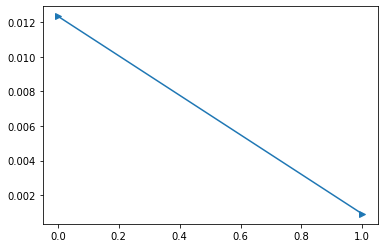

In [50]:
plt.plot(learn.recorder.val_losses, marker='>')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


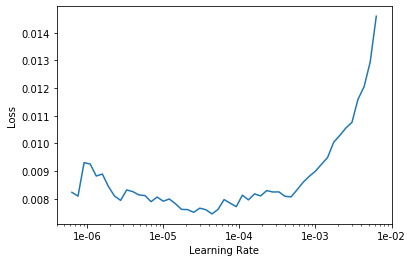

In [51]:
tr.lr_find(learn)
learn.recorder.plot()

In [52]:
lr = 1e-6
learn.fit_one_cycle(2, max_lr=lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.091279,0.001175,00:56
1,0.009961,0.001023,00:56


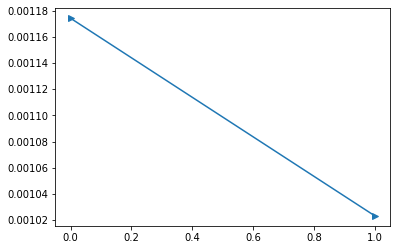

In [53]:
plt.plot(learn.recorder.val_losses, marker='>')

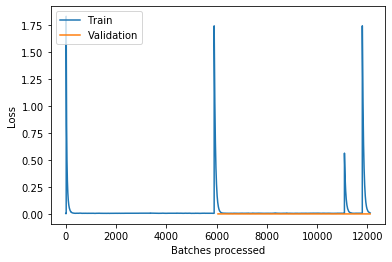

In [54]:
learn.recorder.plot_losses()

In [58]:
model.to('cuda')

AE_big(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (bn5): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (bn6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (bn7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (bn8): BatchNorm1d(200, eps=1e

In [61]:
tr.lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #4 'mat1'

In [27]:
lr = 1e-6
learn.fit_one_cycle(2, max_lr=lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.007305,0.001055,00:56
1,0.007220,0.000939,00:56


In [37]:
learn.data.train_ds.tensors[0][0]

tensor([ 0.6136,  0.0878, -0.8069, -0.5152])

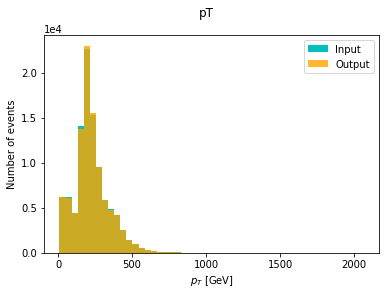

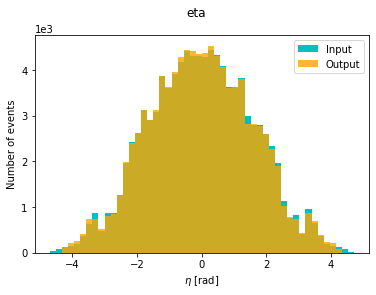

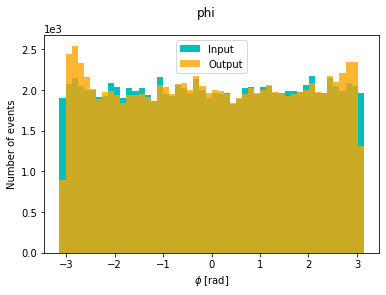

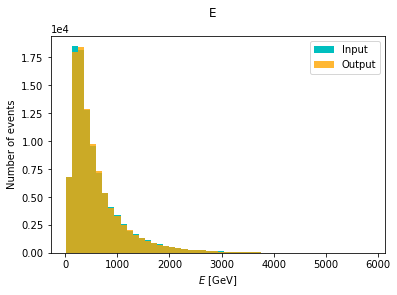

In [60]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

## Check low pT reconstruction

In [62]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train = train[train['pT']<100]
test = test[test['pT']<100]
train.head()

,pT,eta,phi,E
1739612,79.819145,4.535507,-1.185196,3722.832764
213212,74.533775,0.010658,-0.424795,74.770332
133632,73.335709,-0.998801,0.981093,113.546120
1321860,78.281624,1.674880,-2.164416,216.534836
1877459,57.215500,-3.269782,-0.657705,753.719360


In [63]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=512)

db = basic_data.DataBunch(train_dl, valid_dl)

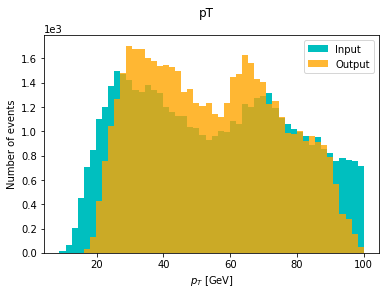

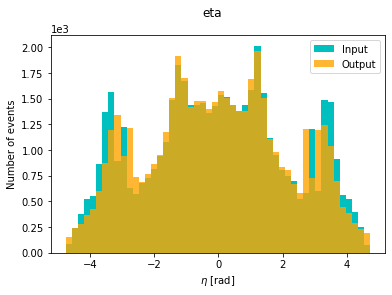

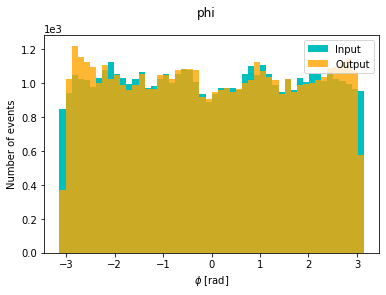

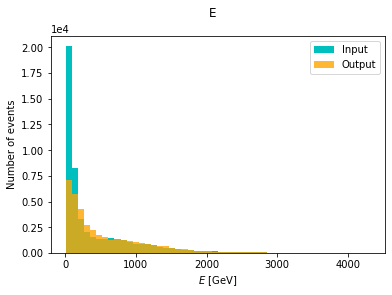

In [64]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()